# Policy Iteration
Reference: https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Policy%20Iteration%20Solution.ipynb

In [1]:
import numpy as np
from gridworld import GridworldEnv
from cliff_walking import CliffWalkingEnv
import matplotlib.pyplot as plt
import time

In [2]:
mdp = 'grid_world'  # Set to the mdp problem to solve
assert mdp in {'grid_world', 'cliff_walking'}
if mdp == 'grid_world':
    env = GridworldEnv(shape=[4, 4])
else:
    env = CliffWalkingEnv()

In [3]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [4]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V, nums_of_states_with_policy_changed). 
        policy: the optimal policy, a matrix of shape [S, A] where each state s
                contains a valid probability distribution over actions.
        V: the value function for the optimal policy
        nums_of_states_with_best_action_changed: num of states with best action changed for each iteration
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    nums_of_states_with_best_action_changed = []
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        num_of_states_with_best_action_changed = 0
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
                num_of_states_with_best_action_changed += 1
            policy[s] = np.eye(env.nA)[best_a]
            
        nums_of_states_with_best_action_changed.append(num_of_states_with_best_action_changed)
        
        # If the policy is stable we've found an optimal policy. Return it
        # NOTE: Do not return just after the 1st iteration, as that result was compared with the initialized
        # random policy, which is not trustworthy at all
        if policy_stable and len(nums_of_states_with_best_action_changed) > 1:
            return policy, V, nums_of_states_with_best_action_changed

Policy iteration converged after 3 iterations in 0.02069091796875 seconds
Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]
Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


Text(0.5, 1.0, 'Num of states with policy changed for each iteration')

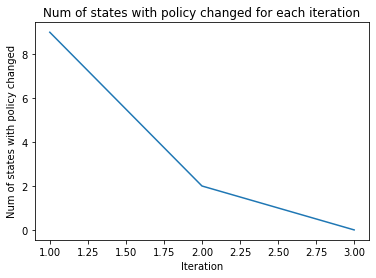

In [5]:
start_time = time.time()
policy, v, nums_of_states_with_best_action_changed = policy_improvement(env)
end_time = time.time()
print('Policy iteration converged after {0} iterations in {1} seconds'
      .format(len(nums_of_states_with_best_action_changed), end_time - start_time))

print("Policy Probability Distribution:")
print(policy)

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))

print("Value Function:")
print(v)

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))

plt.plot(list(range(1, len(nums_of_states_with_best_action_changed) + 1)), nums_of_states_with_best_action_changed)
plt.xlabel('Iteration')
plt.ylabel('Num of states with policy changed')
plt.title('Num of states with policy changed for each iteration')